# Flowers
The mission here is to classify images of flowers using a pre-trained networm and transfer the learning.
The steps will be:
- Download and load images of flowers
- Build a model with convolutional layers
- Fit the model to the images
- Predict and visualise

In [7]:
%load_ext nb_black
import os
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<IPython.core.display.Javascript object>

In [2]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
zip_file = tf.keras.utils.get_file(origin=_URL, fname="flower_photos.tgz", extract=True)
base_dir = os.path.join(os.path.dirname(zip_file), "flower_photos")
classes = ["roses", "daisy", "dandelion", "sunflowers", "tulips"]

<IPython.core.display.Javascript object>

We need to split the flower photos into training and validation sets.
Pick a fraction and move them.

In [3]:
TRAIN_FRACTION = 0.8
total_train = 0
total_val = 0
for flower_type in classes:
    flower_dir = os.path.join(base_dir, flower_type)
    flower_pics = glob.glob(f"{flower_dir}/*.jpg")
    train, val = (
        flower_pics[: round(len(flower_pics) * TRAIN_FRACTION)],
        flower_pics[round(len(flower_pics) * TRAIN_FRACTION) :],
    )
    total_train += len(train)
    total_val += len(val)

    flower_train_dir = os.path.join(base_dir, "train", flower_type)
    flower_val_dir = os.path.join(base_dir, "val", flower_type)
    if not os.path.exists(flower_train_dir):
        os.makedirs(flower_train_dir)
    if not os.path.exists(flower_val_dir):
        os.makedirs(flower_val_dir)

    for pic in train:
        if not os.path.exists(os.path.join(flower_train_dir, pic)):
            shutil.move(pic, flower_train_dir)
    for pic in val:
        if not os.path.exists(os.path.join(flower_val_dir, pic)):
            shutil.move(pic, flower_val_dir)
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

<IPython.core.display.Javascript object>

In [4]:
BATCH_SIZE = 32
IMG_SHAPE = 299

train_image_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,
    horizontal_flip=True,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.5,
    fill_mode="nearest",
)
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    classes=classes,
    class_mode="binary",
)

val_image_generator = ImageDataGenerator(rescale=1.0 / 255.0)
val_data_gen = val_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=val_dir,
    shuffle=False,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    classes=classes,
    class_mode="binary",
)
print(val_data_gen)

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


<IPython.core.display.Javascript object>

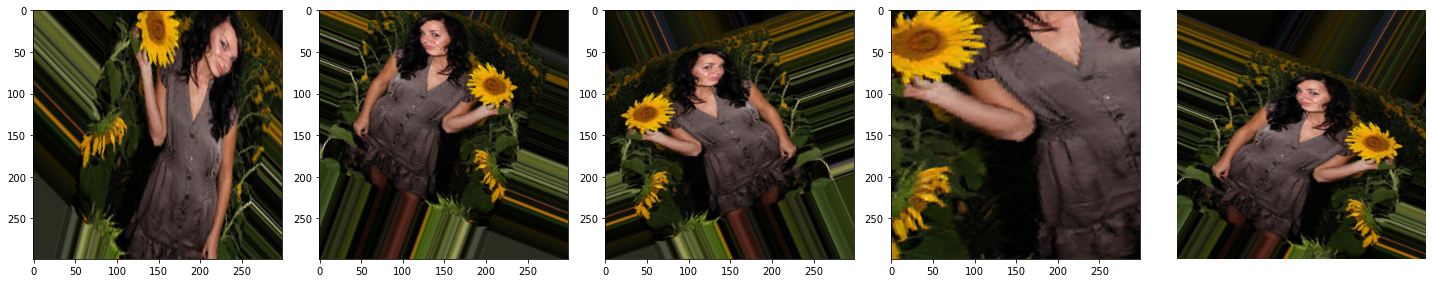

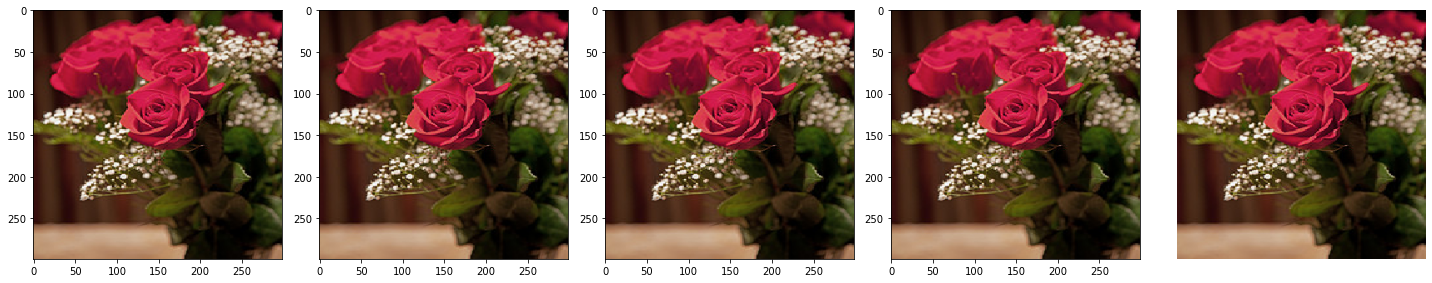

<IPython.core.display.Javascript object>

In [5]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


plot_images([train_data_gen[0][0][0] for _ in range(5)])
plot_images([val_data_gen[0][0][0] for _ in range(5)])

In [10]:
CLASSIFIER_URL = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"

model = tf.keras.Sequential(
    [
        hub.KerasLayer(
            CLASSIFIER_URL, input_shape=(IMG_SHAPE, IMG_SHAPE, 3), trainable=False
        ),
    tf.keras.layers.Dense(len(classes))
])
print(classes)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()


['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


<IPython.core.display.Javascript object>

In [11]:
EPOCHS = 10
with tf.device("/GPU:0"):
    history = model.fit(
        train_data_gen,
        steps_per_epoch=round(total_train / BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=val_data_gen,
        validation_steps=round(total_val / BATCH_SIZE),
    )

Epoch 1/10
92/92 [==============================] - 126s 967ms/step - loss: 1.1271 - accuracy: 0.5533 - val_loss: 0.5283 - val_accuracy: 0.8286
Epoch 2/10
92/92 [==============================] - 60s 651ms/step - loss: 0.5030 - accuracy: 0.8384 - val_loss: 0.4386 - val_accuracy: 0.8503
Epoch 3/10
92/92 [==============================] - 59s 636ms/step - loss: 0.4214 - accuracy: 0.8658 - val_loss: 0.4081 - val_accuracy: 0.8490
Epoch 4/10
92/92 [==============================] - 59s 639ms/step - loss: 0.3923 - accuracy: 0.8645 - val_loss: 0.3752 - val_accuracy: 0.8776
Epoch 5/10
92/92 [==============================] - 58s 628ms/step - loss: 0.3608 - accuracy: 0.8773 - val_loss: 0.3822 - val_accuracy: 0.8667
Epoch 6/10
92/92 [==============================] - 57s 621ms/step - loss: 0.3341 - accuracy: 0.8807 - val_loss: 0.3808 - val_accuracy: 0.8626
Epoch 7/10
92/92 [==============================] - 57s 621ms/step - loss: 0.3141 - accuracy: 0.8908 - val_loss: 0.3645 - val_accuracy: 0.862

<IPython.core.display.Javascript object>

<ipython-input-12-2f8c75174e92>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


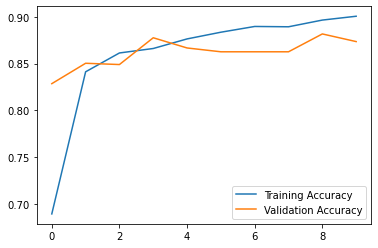

<IPython.core.display.Javascript object>

In [12]:
fig, ax = plt.subplots()
ax.plot(range(EPOCHS), history.history["accuracy"], label="Training Accuracy")
ax.plot(range(EPOCHS), history.history["val_accuracy"], label="Validation Accuracy")
ax.legend()
fig.show()

<ipython-input-13-65e0b284f8a7>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


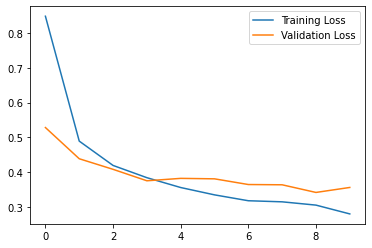

<IPython.core.display.Javascript object>

In [13]:
fig, ax = plt.subplots()
ax.plot(range(EPOCHS), history.history["loss"], label="Training Loss")
ax.plot(range(EPOCHS), history.history["val_loss"], label="Validation Loss")
ax.legend()
fig.show()

In [15]:
export_path = f"./flower-transfer.h5"
model.save(export_path)

<IPython.core.display.Javascript object>

In [16]:
model_reloaded = tf.keras.models.load_model(
    export_path, custom_objects={"KerasLayer": hub.KerasLayer}
)

<IPython.core.display.Javascript object>

In [18]:
image_batch = [train_data_gen[0][, :, :, :]
result_batch = model.predict(image_batch)
reloaded_batch = model_reloaded.predict(image_batch)

TypeError: tuple indices must be integers or slices, not tuple

<IPython.core.display.Javascript object>